# Interactive Model Training, Evaluation, and Explanation Notebook

This notebook demonstrates how to train a convolutional neural network, evaluate its performance, and generate explanations using Grad-CAM and SHAP.

---

### 1. Importing Necessary Modules
First, we need to import all the necessary modules and functions from the corresponding `.py` files.

In [15]:
import torch
import matplotlib.pyplot as plt

from model import Net
from train import train, save_model
from test_ import test, evaluate_model

from gradcam import GradCAM, show_cam_on_image
from shap_explain import compute_shap_values
from utils import get_data_loaders

from torchsummary import summary
import numpy as np

### 2. Setting Up Device and Parameters

Here, we define the device configuration (GPU or CPU) and set hyperparameters like batch size and the number of epochs.


In [2]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parameters
batch_size = 32
num_epochs = 10

### 3. Loading Data

We load the training and testing datasets using our utility function.


In [3]:
train_loader, test_loader, class_names = get_data_loaders(batch_size)

### 4. Model Initialisation

Now, let's initialise our model and optimiser.


In [4]:
model = Net().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

### 5. Training the Model

We can train our model using the training function. Training progress will be displayed during the process.


In [5]:
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimiser, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/5712 (0%)]	Loss: 1.379297
Train Epoch: 1 [3200/5712 (56%)]	Loss: 0.958405

Test set: Average loss: 0.7108, Accuracy: 968/1311 (74%)

Train Epoch: 2 [0/5712 (0%)]	Loss: 0.542773
Train Epoch: 2 [3200/5712 (56%)]	Loss: 0.516253

Test set: Average loss: 0.5145, Accuracy: 1036/1311 (79%)

Train Epoch: 3 [0/5712 (0%)]	Loss: 0.566572
Train Epoch: 3 [3200/5712 (56%)]	Loss: 0.401205

Test set: Average loss: 0.4124, Accuracy: 1099/1311 (84%)

Train Epoch: 4 [0/5712 (0%)]	Loss: 0.281444
Train Epoch: 4 [3200/5712 (56%)]	Loss: 0.163113

Test set: Average loss: 0.3233, Accuracy: 1141/1311 (87%)

Train Epoch: 5 [0/5712 (0%)]	Loss: 0.251588
Train Epoch: 5 [3200/5712 (56%)]	Loss: 0.409180

Test set: Average loss: 0.2689, Accuracy: 1171/1311 (89%)

Train Epoch: 6 [0/5712 (0%)]	Loss: 0.315691
Train Epoch: 6 [3200/5712 (56%)]	Loss: 0.305731

Test set: Average loss: 0.2401, Accuracy: 1189/1311 (91%)

Train Epoch: 7 [0/5712 (0%)]	Loss: 0.034954
Train Epoch: 7 [3200/5712 (56%)]	Loss: 0.1694

### 6. Saving the Model

Once training is complete, we'll save the model for future use.

In [6]:
save_model(model, 'trained_model.pth')

Model saved as 'trained_model.pth'


### 6.5. Load the Saved Model

Load the saved model, prevents retraining each time.

In [7]:
# Load the saved model
model = Net()
model.load_state_dict(torch.load('trained_model.pth', map_location=device))  # Load your trained model
model.to(device)
model.eval()

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3200, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)

### 7. Model Evaluation

We evaluate the model on the test dataset and visualise the results with a confusion matrix.


In [13]:
# Display the model summary
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
              ReLU-2         [-1, 32, 148, 148]               0
         MaxPool2d-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 64, 72, 72]          18,496
              ReLU-5           [-1, 64, 72, 72]               0
         MaxPool2d-6           [-1, 64, 36, 36]               0
            Conv2d-7          [-1, 128, 34, 34]          73,856
              ReLU-8          [-1, 128, 34, 34]               0
         MaxPool2d-9          [-1, 128, 17, 17]               0
           Conv2d-10          [-1, 128, 15, 15]         147,584
             ReLU-11          [-1, 128, 15, 15]               0
        MaxPool2d-12            [-1, 128, 5, 5]               0
          Flatten-13                 [-1, 3200]               0
           Linear-14                  [


Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.91      0.94       300
  meningioma       0.91      0.94      0.92       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



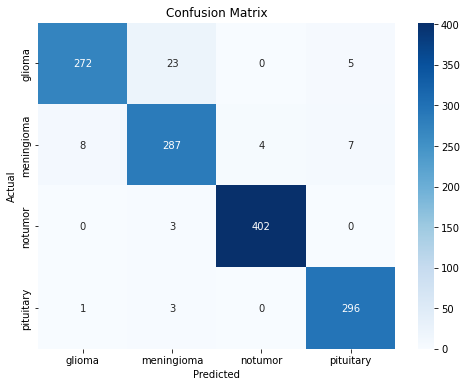

In [14]:
evaluate_model(model, device, test_loader, class_names)

### 8. Grad-CAM Visualisation

Let's generate Grad-CAM visualisations for a few test images.


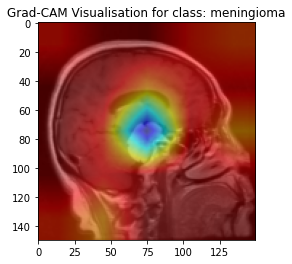

In [23]:
# Grad-CAM setup
target_layer = model.conv_layers[-1]  # Get final conv layer
grad_cam = GradCAM(model, target_layer)

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Generate Grad-CAM for a specific image (e.g., 21st image in the batch)
image = images[21].unsqueeze(0).to(device)
mask = grad_cam(image)

# Prepare the image for display
image_display = images[21].cpu().numpy().transpose(1, 2, 0)
image_display = (image_display - np.min(image_display)) / np.max(image_display)

# Display the Grad-CAM
cam_image = show_cam_on_image(image_display, mask)
plt.imshow(cam_image)
plt.title(f"Grad-CAM Visualisation for class: {class_names[labels[21]]}")
plt.show()

### 9. SHAP Explanation

Finally, we'll compute and visualise SHAP values for a small batch of test images.


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


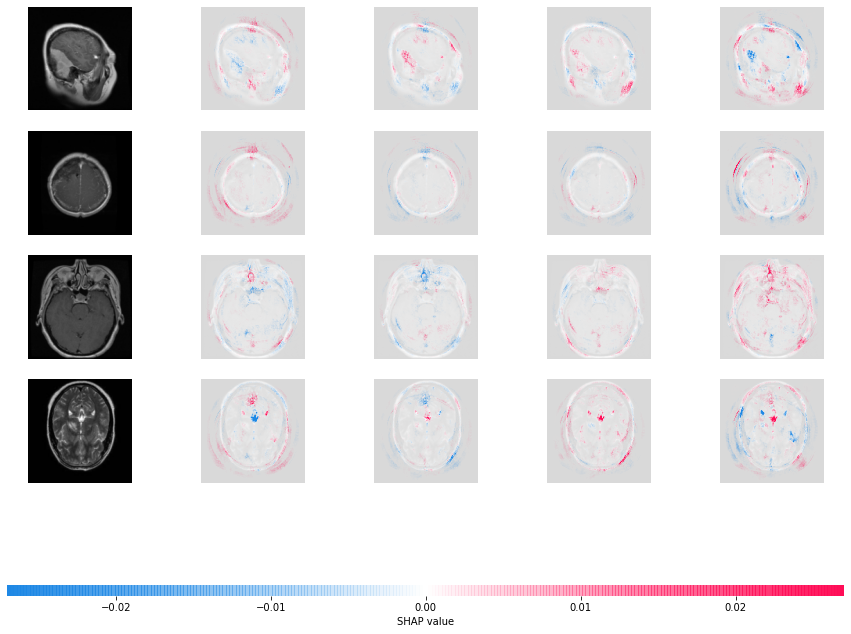

In [17]:
# Select background and test images for SHAP
background = images[:4].to(device)
test_images = images[4:8].to(device)

# Compute and plot SHAP values
compute_shap_values(model, background, test_images)